In [ ]:
# We now test the daily time series by training it on all of the 2023 data and predicted 2024

In [30]:
import pandas as pd

# Load 2023 
daily_counts_jfk_2023 = pd.read_csv("../data/interim/ts_2023.csv")

# Process into a series:
daily_counts_jfk_2023.index = daily_counts_jfk_2023["pickup_date"]
daily_counts_jfk_2023 = daily_counts_jfk_2023.drop("pickup_date", axis = 1)
daily_counts_jfk_2023.columns = ["num_taxis"]

In [6]:
# Load all the 2024 data
import glob

files_2024 = glob.glob("../data/raw/yellow_tripdata_2024*.parquet")

# Load and concatenate all the data into a single data frame:
df_2024 = pd.concat((pd.read_parquet(f) for f in files_2024), ignore_index = True)

In [7]:
df_2024.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [121]:
df_2024.shape

(41169664, 20)

In [122]:
df_2024.isna().sum()

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count          4091232
trip_distance                  0
RatecodeID               4091232
store_and_fwd_flag       4091232
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge     4091232
Airport_fee              4091232
pickup_date                    0
dtype: int64

<Axes: xlabel='pickup_date'>

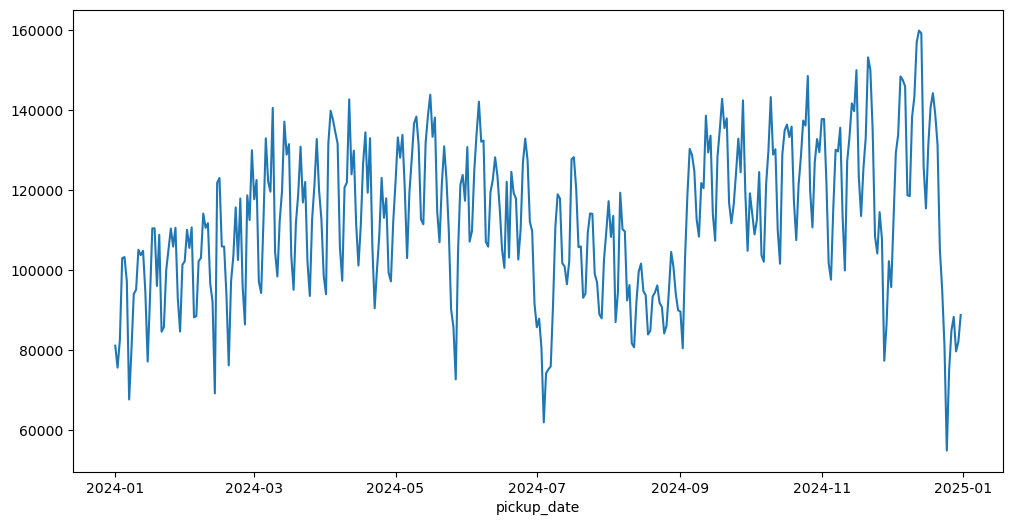

In [123]:
# Daily time series
df_2024['pickup_date'] = df_2024['tpep_pickup_datetime'].dt.date

# Trips per day
daily_counts_2024 = df_2024.groupby('pickup_date').size()

# Plot
daily_counts_2024.plot(figsize = (12,6))

In [124]:
# Get only the rows in 2024:
df_2024 = df_2024[df_2024['tpep_pickup_datetime'].dt.year == 2024]

MemoryError: Unable to allocate 3.68 GiB for an array with shape (12, 41169664) and data type float64

C:\Users\ogilv\AppData\Local\Temp\ipykernel_38084\697257341.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2024['pickup_date'] = df_2024['tpep_pickup_datetime'].dt.date


<Axes: xlabel='pickup_date'>

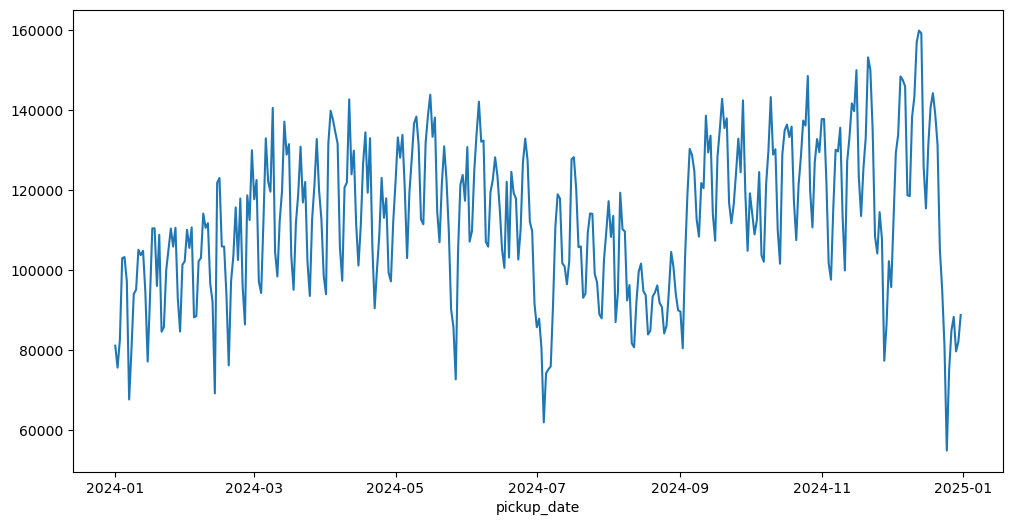

In [14]:
# Daily time series
df_2024['pickup_date'] = df_2024['tpep_pickup_datetime'].dt.date

# Trips per day
daily_counts_2024 = df_2024.groupby('pickup_date').size()

# Plot
daily_counts_2024.plot(figsize = (12,6))

In [15]:
# Get JFK Airport data
df_jfk_2024 = df_2024[df_2024["PULocationID"] == 132].copy() 

In [16]:
df_jfk_2024.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,pickup_date
15,1,2024-01-01 00:50:09,2024-01-01 01:03:57,1.0,5.00,1.0,N,132,216,2,21.2,2.75,0.5,0.0,0.00,1.0,25.45,0.0,1.75,2024-01-01
75,2,2024-01-01 00:46:16,2024-01-01 01:20:10,1.0,20.85,2.0,N,132,239,1,70.0,0.00,0.5,0.0,6.94,1.0,82.69,2.5,1.75,2024-01-01
98,2,2024-01-01 00:50:28,2024-01-01 01:38:39,1.0,20.34,1.0,N,132,26,1,80.0,1.00,0.5,2.0,0.00,1.0,86.25,0.0,1.75,2024-01-01
137,2,2024-01-01 00:06:29,2024-01-01 00:31:26,2.0,16.40,2.0,N,132,170,2,70.0,0.00,0.5,0.0,6.94,1.0,82.69,2.5,1.75,2024-01-01
205,2,2024-01-01 00:55:31,2024-01-01 01:21:15,1.0,18.42,1.0,N,132,213,2,68.1,1.00,0.5,0.0,6.94,1.0,79.29,0.0,1.75,2024-01-01


In [17]:
df_jfk_2024.shape

(1989986, 20)

In [18]:
# Save this as a .parquet to avoid long reload times in future
df_jfk_2024.to_parquet("../data/interim/processed_jfk_2024.parquet")

# To reload:
# df_jfk_2024 = pd.read_parquet("../data/interim/processed_jfk_2024.parquet")

<Axes: xlabel='pickup_date'>

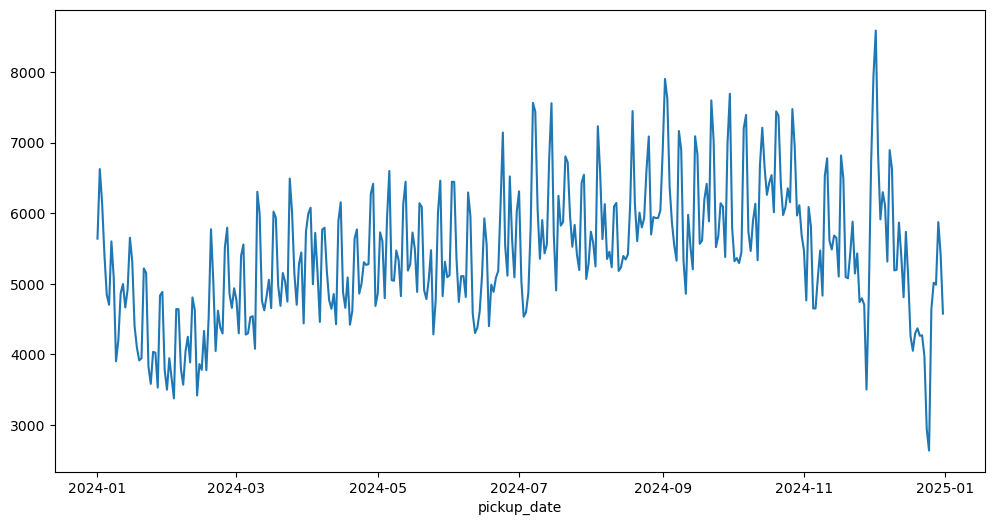

In [19]:
# Daily time series
df_jfk_2024['pickup_date'] = df_jfk_2024['tpep_pickup_datetime'].dt.date

# Trips per day
daily_counts_jfk_2024 = df_jfk_2024.groupby('pickup_date').size()

# Plot
daily_counts_jfk_2024.plot(figsize = (12,6))

In [20]:
# Save the daily counts as a csv
daily_counts_jfk_2024.to_csv("../data/interim/ts_2024.csv")

# Reload
# ts_2024 = pd.read_csv("../data/interim/ts_2024.csv")

In [335]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = daily_counts_jfk_2023

# When forecasting we need the index to have a frequency, for us this is daily
y.index = pd.date_range(start=y.index[0], periods=len(y), freq="D")


dp = DeterministicProcess(
    index = y.index,
    constant = True,   # Dummy feature for bias (y-intercept)
    order = 0,         # Polynomial trend (degree 1 = linear)
    seasonal = True,    # Adds seasonal dummies
    period = 7,        # Weekly seasonality (7-day cycle)
    drop = True,       # Drop first column to avoid collinearity
)

X = dp.in_sample()


In [336]:
# We now add in the lag features.
# The reason we haven't used all the significant lags is we will need to drop the rows that
# contain null values and if we use lag say 49 we will be dropping about 15% of our data

for i in [1, 2, 3, 4, 6, 7, 8, 13, 14, 15]:
    X[f'y_lag_{i}'] = y.shift(i)

# Drop all na rows
mask = X.notna().all(axis=1) # keep only rows with no NaNs
X = X.loc[mask]
y = y.loc[mask]

In [337]:
from sklearn.linear_model import LinearRegression
# Fit the model:

model = LinearRegression(fit_intercept = False)
_ = model.fit(X,y)

In [338]:
# The problem with the above is it is technically cheating as we are assuming we know all the lags in advaance, a more realistic exercise is to try and forecast from our 2023 data itself.
# Meaning we will have to use our own model predicitons to generate the lags:

# Lags we used to train the model
lags = [1, 2, 3, 4, 6, 7, 8, 13, 14, 15]
def forecast(model, y, lags, steps):
    """
    model  = trained linear regression
    y      = pandas Series with historical values
    lags   = list of lags used in training (e.g. [1,2,3])
    steps  = how many steps ahead to forecast
    """
    
    preds = []
    y_hist = y.copy()

    # Create the deterministic features for the forecast
    X_future_det = dp.out_of_sample(steps = steps)

    for i in range(steps): 

        # Get the deterministic row
        x_next = X_future_det.iloc[i].copy()
        
        # Create the lags using historical data
        for j in lags:
            x_next[f'y_lag_{j}'] = y_hist.iloc[-j]
        
        # Predict - x_next is a pandas series and needs to be converted to a dataframe for predictions
        y_pred = model.predict(pd.DataFrame([x_next], columns = x_next.index))[0]
        
        # Append prediction to history so it can be used for future lags
        new_point = pd.Series(y_pred, index=[X_future_det.index[i]])
        y_hist = pd.concat([y_hist, new_point])

        # Add prediction to preds series
        preds.append(new_point)

    # Turn preds into a pandas series
    preds = pd.concat(preds)
    return preds


In [339]:
# For forecasting we need y as a Series not a DataFrame:
y = y.iloc[:, 0]


In [340]:
print(forecast(model, y, lags, 10))


2024-01-01    5219.410665
2024-01-02    4786.230573
2024-01-03    4717.242170
2024-01-04    4848.773521
2024-01-05    4980.616331
2024-01-06    4634.128812
2024-01-07    5667.101576
2024-01-08    5760.051624
2024-01-09    5035.014387
2024-01-10    4870.844983
dtype: float64


In [343]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error


# Create forecasts, plot and compare to naive baseline
def test_forecasts(steps, y_test, y_hist, model):
    """
    steps = array of the step lengths to forecast
    y_test = pd.Series of the true future values
    y_hist = pd.Series of historical values
    model = model to use for forecasting
    """

    # Compute naive predictions
    # Today = yesterday
    y_pred_naive = y_test.shift(1)
    y_pred_naive.iloc[0] = y_hist.iloc[-1]
    
    print(y_pred_naive) 
    
    for step in steps:
        # Forecast
        y_fore = forecast(model, y_hist, lags, step)

        # Get real values
        y_real = y_test.iloc[0:step]

        # Compute MAE
        mae = mean_absolute_error(y_fore, y_real)
        print(f"MAE: {mae:.2f} for step = {step}")
        
        # Compute naive MAE
        y_step_pred_naive = y_pred_naive.loc[y_real.index]
         
        mae_naive = mean_absolute_error(y_real, y_step_pred_naive)
        print(f"Naive MAE: MAE = {mae_naive:.2f}\n")

        # Plot
        ax = y_real.plot(color='0.25', style='.', title=f"Forecast steps: {step}")
        ax = y_fore.plot(ax=ax, label="Forecast")
        ax = y_step_pred_naive.plot(ax = ax, label = "Naive")
        ax.legend()
        plt.xticks(rotation = 90)
        plt.show()
       

pickup_date
2024-01-01    5296.0
2024-01-02    5638.0
2024-01-03    6624.0
2024-01-04    6139.0
2024-01-05    5405.0
               ...  
2024-12-27    4638.0
2024-12-28    5013.0
2024-12-29    4985.0
2024-12-30    5873.0
2024-12-31    5413.0
Length: 366, dtype: float64
MAE: 418.59 for step = 1
Naive MAE: MAE = 342.00



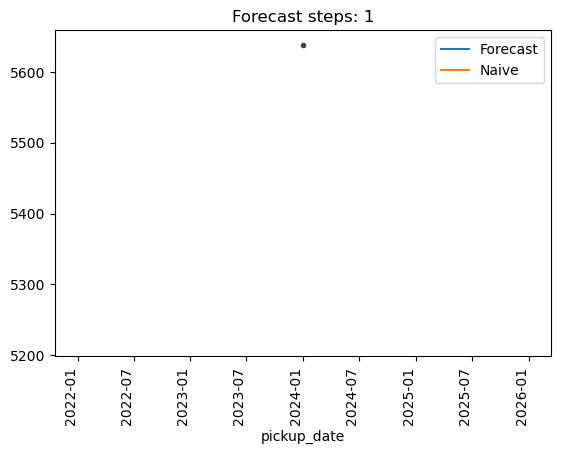

MAE: 1128.18 for step = 2
Naive MAE: MAE = 664.00



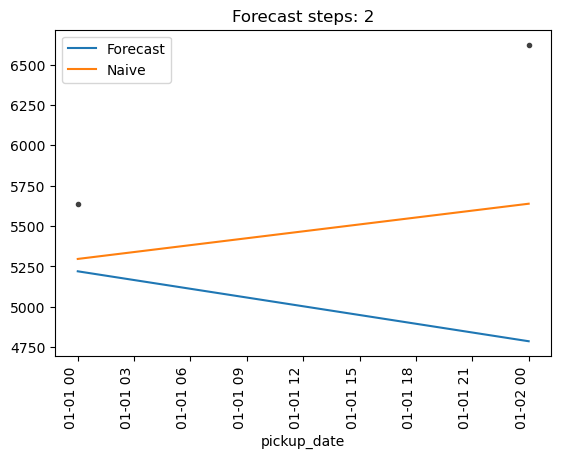

MAE: 1226.04 for step = 3
Naive MAE: MAE = 604.33



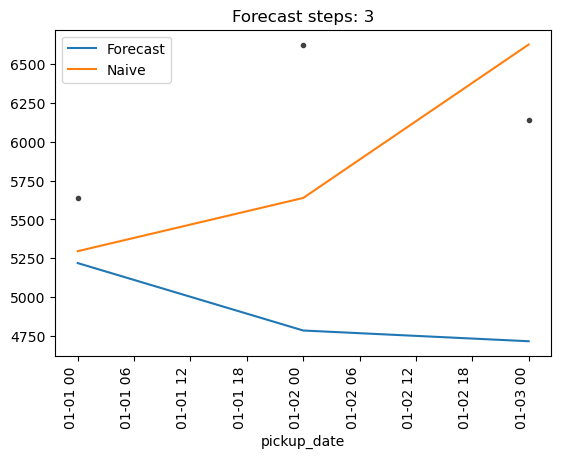

MAE: 643.99 for step = 7
Naive MAE: MAE = 592.71



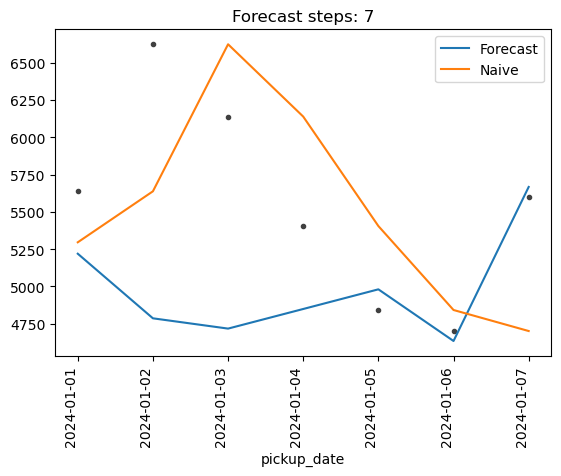

MAE: 610.67 for step = 14
Naive MAE: MAE = 537.71



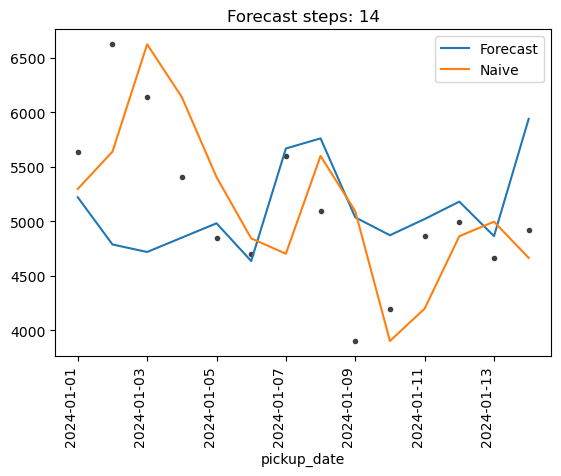

MAE: 782.47 for step = 28
Naive MAE: MAE = 543.11



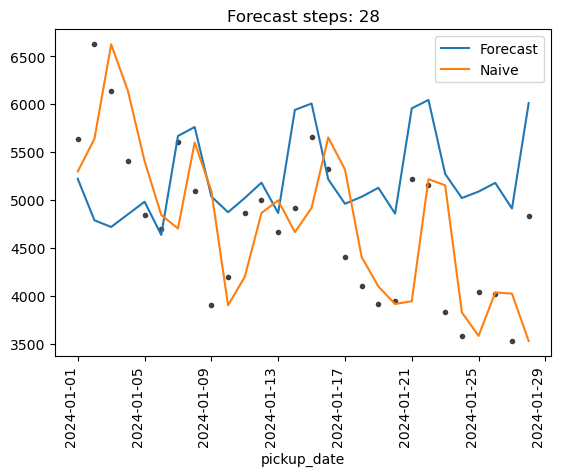

MAE: 822.32 for step = 30
Naive MAE: MAE = 545.37



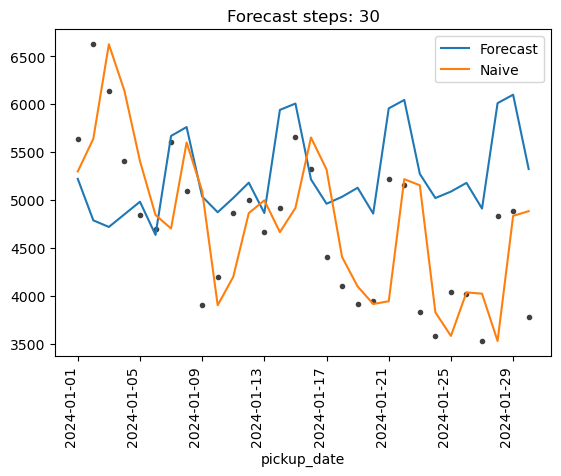

In [344]:
# Run these test forecasts:
steps = [1, 2, 3, 7, 14, 28, 30]

y_test = daily_counts_jfk_2024

test_forecasts(steps, y_test, y, model)

Based on the above I now have the suspicision that the deterministic part of the linear regression is causing problems with the forecast. We will now make new model using only lags and redo the forecasting to compare. 

In [350]:
# Create lag design matrix and target series
y_lag = daily_counts_jfk_2023.copy()

# When forecasting we need the index to have a frequency, for us this is daily
y_lag.index = pd.date_range(start=y_lag.index[0], periods=len(y_lag), freq="D")

# Create emty lag data frame
X_lag = pd.DataFrame(index = y_lag.index)

lags = [1, 2, 3, 4, 6, 7, 8, 13, 14, 15]
for i in lags:
    X_lag[f'y_lag_{i}'] = y.shift(i)

# Drop all na rows
mask = X_lag.notna().all(axis=1) # keep only rows with no NaNs
X_lag = X_lag.loc[mask]
y_lag = y_lag.loc[mask]


In [355]:
from xgboost import XGBRegressor

# Fit the model:

# Linear:
model_lag = LinearRegression()
model_lag.fit(X_lag, y_lag);

# XGBoost:
model_xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8
)
model_xgb.fit(X_lag, y_lag);

In [356]:
# The problem with the above is it is technically cheating as we are assuming we know all the lags in advaance, a more realistic exercise is to try and forecast from our 2023 data itself.
# Meaning we will have to use our own model predicitons to generate the lags:

def forecast_lag(model, y, lags, steps):
    """
    model  = trained linear regression
    y      = pandas Series with historical values
    lags   = list of lags used in training (e.g. [1,2,3])
    steps  = how many steps ahead to forecast
    """
    
    preds = []
    y_hist = y.copy()

    for i in range(1, steps + 1): 

        # Create the next row
        next_index = y_hist.index.freq  + y_hist.index[-1]
       
        next_index = next_index.date() # convert to date
        x_next = pd.DataFrame(index = [next_index])
        
        # Create the lags using historical data
        for j in lags:
            x_next[f'y_lag_{j}'] = y_hist.iloc[-j]

        
        # Predict - x_next is a pandas series and needs to be converted to a dataframe for predictions
        y_pred = model.predict(x_next)[0]
        
        # Append prediction to history so it can be used for future lags
        new_point = pd.Series(y_pred, index=x_next.index)
        y_hist = pd.concat([y_hist, new_point])

        # Reset y_hist's index
        y_hist.index = pd.date_range(start=y_hist.index[0], periods=len(y_hist), freq="D")


        # Add prediction to preds series
        preds.append(new_point)

    # Turn preds into a pandas series
    preds = pd.concat(preds)
    return preds


In [357]:
# Create forecasts, plot and compare to naive baseline
def test_forecasts_lag(steps, y_test, y_hist, model):
    """
    steps = array of the step lengths to forecast
    y_test = pd.Series of the true future values
    y_hist = pd.Series of historical values
    model = model to use for forecasting
    """

    # Compute naive predictions
    # Today = yesterday
    y_pred_naive = y_test.shift(1)
    y_pred_naive.iloc[0] = y_hist.iloc[-1]
    
    
    for step in steps:
        # Forecast
        y_fore = forecast_lag(model, y_hist, lags, step)
        y_fore.index.name = "pickup_date"
       
        
        # Get real values
        y_real = y_test.iloc[0:step]

        print(y_fore)

        # Compute MAE
        mae = mean_absolute_error(y_fore, y_real)
        print(f"MAE: {mae:.2f} for step = {step}")
        
        # Compute naive MAE
        y_step_pred_naive = y_pred_naive.loc[y_real.index] 
        mae_naive = mean_absolute_error(y_real, y_step_pred_naive)
        print(f"Naive MAE: MAE = {mae_naive:.2f}\n")


        # Plot
        ax = y_real.plot(color='0.25', style='.', title=f"Forecast steps: {step}")
        ax = y_fore.plot(ax=ax, label="Forecast")
        ax = y_step_pred_naive.plot(ax = ax, label = "Naive")
        ax.legend()
        plt.xticks(rotation = 90)
        plt.show()
       

pickup_date
2024-01-01    5355.571289
dtype: float32
MAE: 282.43 for step = 1
Naive MAE: MAE = 342.00



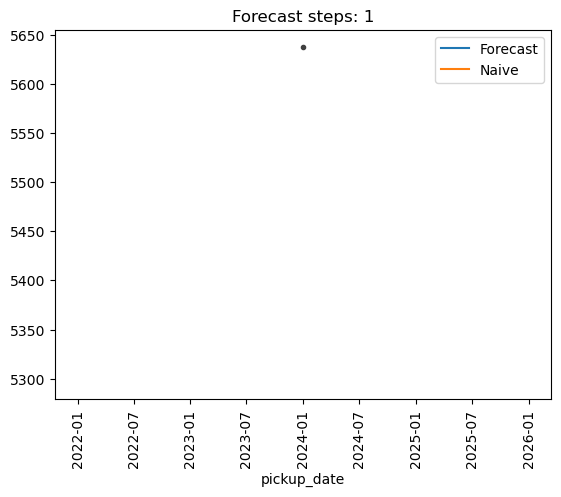

pickup_date
2024-01-01    5355.571289
2024-01-02    5241.939453
dtype: float32
MAE: 832.24 for step = 2
Naive MAE: MAE = 664.00



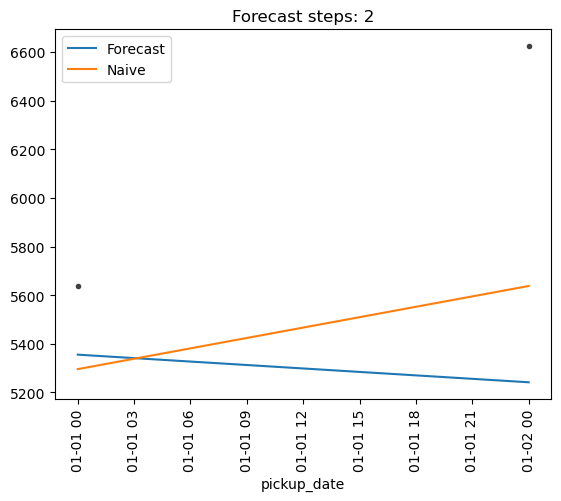

pickup_date
2024-01-01    5355.571289
2024-01-02    5241.939453
2024-01-03    5286.833008
dtype: float32
MAE: 838.89 for step = 3
Naive MAE: MAE = 604.33



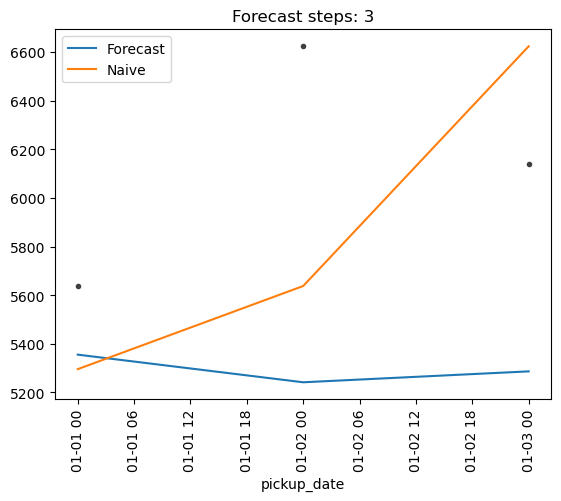

pickup_date
2024-01-01    5355.571289
2024-01-02    5241.939453
2024-01-03    5286.833008
2024-01-04    5198.951660
2024-01-05    5126.993652
2024-01-06    5275.022461
2024-01-07    5275.770508
dtype: float32
MAE: 557.85 for step = 7
Naive MAE: MAE = 592.71



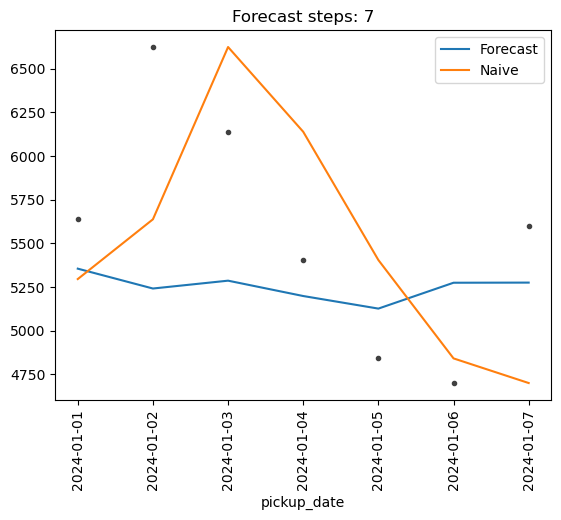

pickup_date
2024-01-01    5355.571289
2024-01-02    5241.939453
2024-01-03    5286.833008
2024-01-04    5198.951660
2024-01-05    5126.993652
2024-01-06    5275.022461
2024-01-07    5275.770508
2024-01-08    5167.475098
2024-01-09    4958.517578
2024-01-10    5003.414551
2024-01-11    5048.359863
2024-01-12    4858.320801
2024-01-13    4641.183594
2024-01-14    4550.153809
dtype: float32
MAE: 468.29 for step = 14
Naive MAE: MAE = 537.71



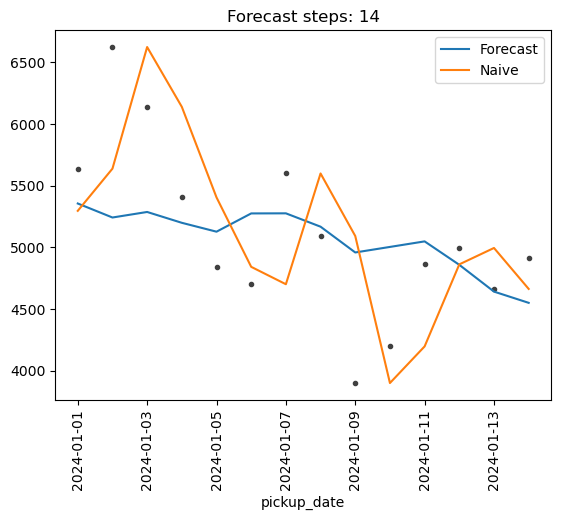

pickup_date
2024-01-01    5355.571289
2024-01-02    5241.939453
2024-01-03    5286.833008
2024-01-04    5198.951660
2024-01-05    5126.993652
2024-01-06    5275.022461
2024-01-07    5275.770508
2024-01-08    5167.475098
2024-01-09    4958.517578
2024-01-10    5003.414551
2024-01-11    5048.359863
2024-01-12    4858.320801
2024-01-13    4641.183594
2024-01-14    4550.153809
2024-01-15    4421.808105
2024-01-16    4516.991211
2024-01-17    4438.766113
2024-01-18    4324.243164
2024-01-19    4279.964844
2024-01-20    4045.195557
2024-01-21    3816.611084
2024-01-22    4076.705811
2024-01-23    4706.329102
2024-01-24    4698.334473
2024-01-25    4630.409180
2024-01-26    4459.244141
2024-01-27    4388.380371
2024-01-28    4354.361328
dtype: float32
MAE: 577.41 for step = 28
Naive MAE: MAE = 543.11



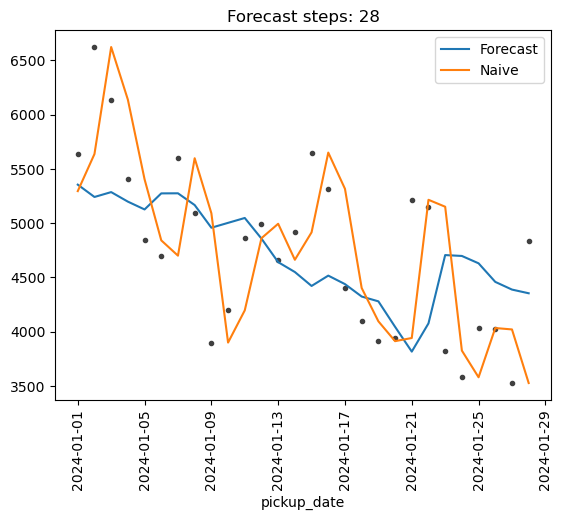

pickup_date
2024-01-01    5355.571289
2024-01-02    5241.939453
2024-01-03    5286.833008
2024-01-04    5198.951660
2024-01-05    5126.993652
2024-01-06    5275.022461
2024-01-07    5275.770508
2024-01-08    5167.475098
2024-01-09    4958.517578
2024-01-10    5003.414551
2024-01-11    5048.359863
2024-01-12    4858.320801
2024-01-13    4641.183594
2024-01-14    4550.153809
2024-01-15    4421.808105
2024-01-16    4516.991211
2024-01-17    4438.766113
2024-01-18    4324.243164
2024-01-19    4279.964844
2024-01-20    4045.195557
2024-01-21    3816.611084
2024-01-22    4076.705811
2024-01-23    4706.329102
2024-01-24    4698.334473
2024-01-25    4630.409180
2024-01-26    4459.244141
2024-01-27    4388.380371
2024-01-28    4354.361328
2024-01-29    4289.651855
2024-01-30    4328.408203
dtype: float32
MAE: 577.04 for step = 30
Naive MAE: MAE = 545.37



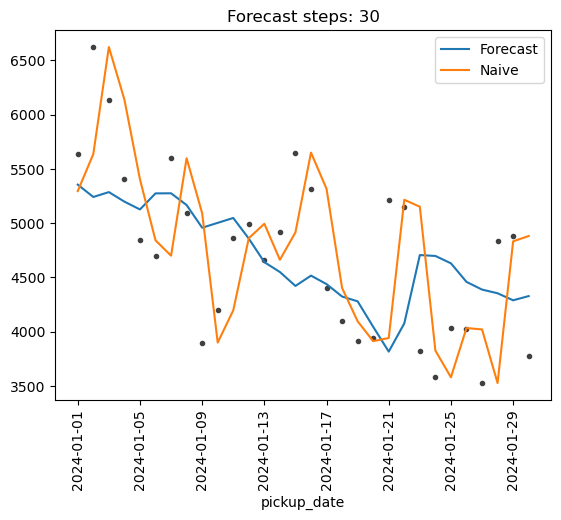

In [358]:
# Run these test forecasts:
steps = [1, 2, 3, 7, 14, 28, 30]

y_test = daily_counts_jfk_2024
y_hist = daily_counts_jfk_2023.iloc[:, 0]
y_hist.index = pd.date_range(start=y_hist.index[0], periods=len(y_hist), freq="D")

test_forecasts_lag(steps, y_test, y_hist, model_xgb)

In [329]:
y_hist

2023-01-01    5582.0
2023-01-02    6419.0
2023-01-03    6784.0
2023-01-04    6006.0
2023-01-05    5617.0
               ...  
2023-12-27    6027.0
2023-12-28    6014.0
2023-12-29    5755.0
2023-12-30    5733.0
2023-12-31    5296.0
Freq: D, Name: num_taxis, Length: 365, dtype: float64